In [1]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import mlflow

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from PIL import Image
import copy

from sklearn.metrics import f1_score, accuracy_score, classification_report,  confusion_matrix

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import mlflow
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
mlflow.set_experiment("Final_project_sign_recognition_20_frames_with_padding&flipping&ugumentation_test")
mlflow.set_tracking_uri("./final_project_sign_recognition/mlruns")

2024/06/19 12:02:23 INFO mlflow.tracking.fluent: Experiment with name 'Final_project_sign_recognition_20_frames_with_padding&flipping&ugumentation_test' does not exist. Creating a new experiment.


In [3]:
keypoints_var = '_20_frames_with_padding&flipping&ugumentation'

In [4]:
DATA_DIR = 'slovo'
TRAIN_DIR = os.path.join(DATA_DIR, 'train_100')
TEST_DIR = os.path.join(DATA_DIR, 'test_100')
ann_100 = pd.read_csv(os.path.join(DATA_DIR, 'annotations_100.csv'))
ann_100

,attachment_id,text,user_id,height,width,length,train,frame_count,height_width
0,5ce6ce8a-d191-47d4-97b4-3fc6f9138a73,я,185bd3a81d9d618518d10abebf0d17a8,1920,1080,91.0,True,51,1920_1080
1,c9e2dbd1-ec2f-4382-a80e-5bca8396a9b1,я,46dd04a1caa75ed3082b573cb5a3ad26,1920,1080,58.0,True,58,1920_1080
2,3f72244c-7379-4403-b7ee-e1b1b8d78d46,я,db573f94204e56e0cf3fc2ea000e5bdc,1280,720,49.0,True,49,1280_720
3,5adf08e2-4ff6-4183-ba22-446c1cd0b0f8,я,0211b488644476dd0fec656ccb9b74fc,1920,1080,50.0,True,50,1920_1080
4,13a148fc-a546-47ab-b5d0-f9d0c3cce1de,я,2d84da20c251acaeb3186642fcb04f2e,1920,1080,27.0,True,27,1920_1080
...,...,...,...,...,...,...,...,...,...
1995,74db1174-1314-43c7-bb8a-cc5cce5e2510,редко,f2dc6eab563f93d86629c1cfe479f09d,1440,1440,56.0,False,56,1440_1440
1996,5d742908-98ce-4172-bb2f-02f3595860a4,редко,798aa826b6129d33f72f62d4ba60b681,720,1280,61.0,False,61,720_1280
1997,dfe2ff4c-98fa-4ead-b861-f499f570a321,месяц,798aa826b6129d33f72f62d4ba60b681,720,1280,58.0,False,58,720_1280
1998,04856a31-8326-49cb-8e0c-0843c64a1d92,время,798aa826b6129d33f72f62d4ba60b681,720,1280,52.0,False,52,720_1280


In [5]:
ann_100[ann_100['frame_count']<20]

,attachment_id,text,user_id,height,width,length,train,frame_count,height_width
882,c4b9f411-fdb0-4efb-b69f-d4bca355faa8,тебе,0211b488644476dd0fec656ccb9b74fc,1920,1080,18.0,True,18,1920_1080
907,60071794-b6d5-437a-a15d-fbfdf67d4d60,тебе,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,19.0,True,19,1920_822
1314,71c2dd1a-e1cd-4c94-9a86-b95dab17191c,ваш,46dd04a1caa75ed3082b573cb5a3ad26,1920,822,19.0,True,19,1920_822
1563,e8d9ec64-798d-453c-9752-81a7349c1860,бежевый,9f9b13d8e63bd774b4ad1bd14f56147d,720,1280,18.0,False,18,720_1280
1968,5e393786-bc2b-46ae-84d9-e3911d754a3b,тебя,64df6876c23bf021dbfbccbc64f7406a,1920,920,18.0,False,18,1920_920


In [6]:
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train_data_2.csv'))
val_data = pd.read_csv(os.path.join(DATA_DIR, 'val_data_2.csv'))
train_data = result = pd.concat([train_data, val_data])
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test_data_2.csv'))

video_id_train, label_train = train_data['video_file'].values, train_data['label'].values
video_id_test, label_test = test_data['video_file'].values, test_data['label'].values

In [7]:
class_data2 = pd.read_csv(os.path.join(DATA_DIR, 'class_data_3.csv'))
class_data2 = class_data2.set_index('label')['class_name'].to_dict()

In [8]:
class_data2

{0: 'я',
 1: 'дикое животное',
 2: 'попугай',
 3: 'кошка',
 4: 'собака',
 5: 'рыба',
 6: 'птица',
 7: 'домашнее животное',
 8: 'добрый',
 9: 'сильный',
 10: 'недобрый',
 11: 'красивый',
 12: 'агрессивный',
 13: 'оранжевый',
 14: 'серебро',
 15: 'бежевый',
 16: 'фиолетовый',
 17: 'желтый',
 18: 'красный',
 19: 'черный',
 20: 'серый',
 21: 'синий',
 22: 'зелёный',
 23: 'белый',
 24: 'напуганный',
 25: 'нравиться',
 26: 'расстроенный',
 27: 'счастливый',
 28: 'благодарю',
 29: 'любить',
 30: 'резервирование; бронирование',
 31: 'кафетерий',
 32: 'женский туалет',
 33: 'мужской туалет',
 34: 'пока',
 35: 'привет',
 36: 'дочь',
 37: 'не',
 38: 'семья',
 39: 'мужчина',
 40: 'отец',
 41: 'дом',
 42: 'женщина',
 43: 'муж',
 44: 'магазин',
 45: 'еда',
 46: 'комната',
 47: 'вчера',
 48: 'месяц',
 49: 'немного',
 50: 'завтра',
 51: 'сестра',
 52: 'ночь',
 53: 'говорить',
 54: 'утро',
 55: 'ребёнок',
 56: 'много',
 57: 'дорога',
 58: 'цена',
 59: 'мне',
 60: 'тебе',
 61: 'сын',
 62: 'сегодня',
 63

# Keypoints loading

In [9]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)
    return data, new_labels

In [10]:
df1 = pd.read_parquet('slovo/train_keypoints_7/c4b9f411-fdb0-4efb-b69f-d4bca355faa8.parquet')
df1[80:]

,frame,variation,pose,left_hand,right_hand
80,16.0,original,"[0.0, 0.0, 0.0, 0.019422590732574463, -0.02855...","[0.0, 0.0, 0.0, -0.05968523025512695, -0.04781...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
81,16.0,contrast,"[0.0, 0.0, 0.0, 0.021153271198272705, -0.02833...","[0.0, 0.0, 0.0, -0.05506235361099243, -0.04735...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
82,16.0,sharpness,"[0.0, 0.0, 0.0, 0.023626327514648438, -0.02823...","[0.0, 0.0, 0.0, -0.050267040729522705, -0.0409...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
83,16.0,brightness,"[0.0, 0.0, 0.0, 0.024414896965026855, -0.02823...","[0.0, 0.0, 0.0, -0.044567227363586426, -0.0347...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
84,16.0,flipped,"[0.0, 0.0, 0.0, 0.016554653644561768, -0.02842...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0608808696269989, -0.0428566..."
85,17.0,original,"[0.0, 0.0, 0.0, 0.01807689666748047, -0.028668...","[0.0, 0.0, 0.0, -0.06959986686706543, -0.03684...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
86,17.0,contrast,"[0.0, 0.0, 0.0, 0.02003026008605957, -0.028277...","[0.0, 0.0, 0.0, -0.05398988723754883, -0.03298...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
87,17.0,sharpness,"[0.0, 0.0, 0.0, 0.02202826738357544, -0.028153...","[0.0, 0.0, 0.0, -0.06601619720458984, -0.03037...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
88,17.0,brightness,"[0.0, 0.0, 0.0, 0.023551106452941895, -0.02818...","[0.0, 0.0, 0.0, -0.048484206199645996, -0.0322...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
89,17.0,flipped,"[0.0, 0.0, 0.0, 0.019654393196105957, -0.02841...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.059528619050979614, -0.04043..."


In [11]:
# Список файлов и меток для тренировочных, валидационных и тестовых наборов
train_keypoints = [f'{DATA_DIR}\\train_keypoints_7\\{f}.parquet' for f in video_id_train]
test_keypoints = [f'{DATA_DIR}\\test_keypoints_5\\{f}.parquet' for f in video_id_test]

# Загрузка данных и меток
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [12]:
print(len(train_keypoints))
print(train_data.shape)
print(test_data.shape)

1500
(7500, 20, 225)
(500, 20, 225)


# SVM

In [13]:
# Изменение формы данных для StandardScaler
n_samples, n_frames, n_features = train_data.shape
train_data_flat = train_data.reshape(n_samples, n_frames * n_features)
test_data_flat = test_data.reshape(test_data.shape[0], n_frames * n_features)

train_data_flat.shape

(7500, 4500)

In [14]:
# Нормализация данных
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data_flat)
test_data_normalized = scaler.transform(test_data_flat)

# Создание и обучение модели SVM
# model = SVC(kernel='linear')
model = SVC(kernel='rbf', C = 100, random_state=42)
# model = SVC(kernel='poly', degree=2, random_state=42)
# model = SVC(kernel='sigmoid', random_state=42)
model.fit(train_data_normalized, train_labels)


# Оценка модели на тестовых данных
test_predictions = model.predict(test_data_normalized)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.25      0.40      0.31         5
           1       1.00      0.80      0.89         5
           2       0.17      0.60      0.26         5
           3       0.75      0.60      0.67         5
           4       0.00      0.00      0.00         5
           5       1.00      0.80      0.89         5
           6       1.00      0.60      0.75         5
           7       0.60      0.60      0.60         5
           8       0.29      0.40      0.33         5
           9       0.67      0.40      0.50         5
          10       0.50      0.20      0.29         5
          11       0.67      0.40      0.50         5
          12       0.25      0.20      0.22         5
          13       0.29      0.40      0.33         5
          14       0.00      0.00      0.00         5
          15       0.22      0.40      0.29         5
          16       0.50      0.20      0.29         5
       

In [15]:
with mlflow.start_run(run_name=f"SVM_rbf kernel{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "SVM")

    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted') 

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

# Naive Bayes classifier

In [16]:
model = MultinomialNB()
model.fit(train_data_normalized, train_labels)

# Оценка модели на тестовых данных
test_predictions = model.predict(test_data_normalized)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.142
              precision    recall  f1-score   support

           0       0.04      0.20      0.06         5
           1       0.50      0.20      0.29         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.17      0.20      0.18         5
           7       0.12      0.20      0.15         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       1.00      0.20      0.33         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         5
      

In [17]:
with mlflow.start_run(run_name=f"NaiveBayesClassifier{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "NaiveBayesClassifier")

    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted') 

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

# LogisticRegression

In [18]:
model = Pipeline([
    ('normalisation', MinMaxScaler()),
    ("linear_regression", LogisticRegression(penalty='l2', C=0.5))])

model.fit(train_data_normalized, train_labels)
test_predictions = model.predict(test_data_normalized)

print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.67      0.80      0.73         5
           2       0.08      0.40      0.13         5
           3       1.00      0.20      0.33         5
           4       0.00      0.00      0.00         5
           5       0.33      0.40      0.36         5
           6       1.00      0.40      0.57         5
           7       0.67      0.40      0.50         5
           8       0.75      0.60      0.67         5
           9       0.50      0.40      0.44         5
          10       0.50      0.20      0.29         5
          11       0.33      0.20      0.25         5
          12       0.33      0.20      0.25         5
          13       0.50      0.60      0.55         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       1.00      0.40      0.57         5
          17       1.00    

In [19]:
with mlflow.start_run(run_name=f"LogisticRegression{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "LogisticRegression")

    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted') 

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

# RandomForest

In [20]:
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(train_data_normalized, train_labels)

# Оценка модели на тестовых данных
test_predictions = model.predict(test_data_normalized)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Test Accuracy: {test_accuracy}')
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.582
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.71      1.00      0.83         5
           2       0.67      0.40      0.50         5
           3       0.67      0.40      0.50         5
           4       0.50      0.20      0.29         5
           5       0.75      0.60      0.67         5
           6       0.75      0.60      0.67         5
           7       0.67      0.80      0.73         5
           8       0.57      0.80      0.67         5
           9       0.60      0.60      0.60         5
          10       0.29      0.40      0.33         5
          11       0.75      0.60      0.67         5
          12       0.33      0.20      0.25         5
          13       0.50      0.60      0.55         5
          14       1.00      0.20      0.33         5
          15       0.00      0.00      0.00         5
          16       0.60      0.60      0.60         5
      

In [21]:
with mlflow.start_run(run_name=f"RandomForestClassifier{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "RandomForestClassifier")

    accuracy = accuracy_score(test_labels, test_predictions)
    f1 = f1_score(test_labels, test_predictions, average='weighted') 

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

# Vanilla_NN

In [22]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)

    n_samples, n_frames, n_features = data.shape
    data_flat = data.reshape(n_samples, n_frames * n_features)

    return data_flat, new_labels   


class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [23]:
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [24]:
device = 'cpu'

train_dataset = KeypointDataset(train_data, train_labels)
test_dataset = KeypointDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [25]:
num_classes = 100  # Количество категорий жестов

class Vanilla_NN(nn.Module):
    def __init__(self):
        super(Vanilla_NN, self).__init__()
        
        self.fc1 = nn.Linear(225*20, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [26]:
model = Vanilla_NN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 30
early_stopping_patience = 10
no_improve_epochs = 0

train_loss_values = [] # в итоге будет длина кол-во эпох
test_loss_values = []

best_loss = None
best_model_state = None

Epoch: 16, Train Loss: 0.201, Test Loss: 3.129:  50%|█████     | 15/30 [05:15<05:15, 21.00s/it]


Early stopping triggered. No improvement in 10 epochs.
Best model reinstated with test loss = 2.5491


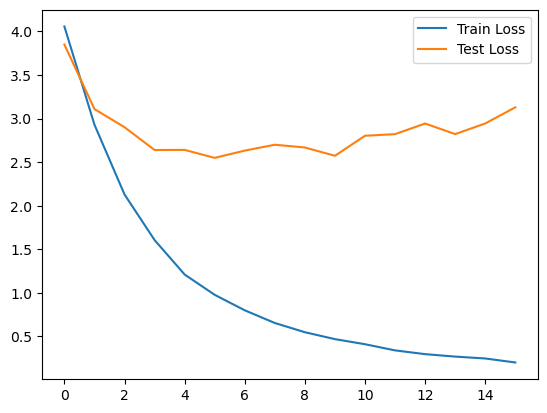

In [27]:
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    running_loss = 0.0
    
    # Training loop
    model.train()
    for i, (_X, _y) in enumerate(train_loader): # использование нижних подчеркиваний перед переменными обычно означает, что эти переменные являются временными
        _X, _y = _X.to(device), _y.to(device)
        optimizer.zero_grad()
        outputs = model(_X)
        loss = criterion(outputs, _y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (_X, _y) in test_loader:
            _X, _y = _X.to(device), _y.to(device)
            outputs = model(_X)
            loss = criterion(outputs, _y)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)

    if best_loss is None or avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

    if no_improve_epochs >= early_stopping_patience:
        print(f'Early stopping triggered. No improvement in {early_stopping_patience} epochs.')
        break

print(f'Best model reinstated with test loss = {best_loss:.4f}')
model.load_state_dict(best_model_state)

plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.legend()
plt.show()     

In [28]:
data_iter = iter(train_loader)
first_batch = next(data_iter)

# Извлекаем данные и метки из первого батча
data, target = first_batch

data.size()

torch.Size([64, 4500])

In [29]:
model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data.astype('float32')).to(device))
    _, predicted = torch.max(outputs, 1)
    f1 =  f1_score(test_labels, predicted.numpy(), average='weighted')
    accuracy = accuracy_score(test_labels, predicted.numpy()) 
    print(classification_report(test_labels, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       1.00      0.60      0.75         5
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.40      0.40      0.40         5
           6       0.80      0.80      0.80         5
           7       0.57      0.80      0.67         5
           8       0.36      0.80      0.50         5
           9       0.33      0.20      0.25         5
          10       1.00      0.20      0.33         5
          11       0.25      0.40      0.31         5
          12       0.33      0.20      0.25         5
          13       0.21      0.60      0.32         5
          14       0.33      0.60      0.43         5
          15       0.14      0.20      0.17         5
          16       1.00      0.20      0.33         5
          17       0.80    

In [30]:
with mlflow.start_run(run_name=f"VanillaNN{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "VanillaNN")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

2024/06/19 12:27:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# LSTMModel

In [31]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)

    return data, new_labels   


class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [32]:
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [33]:
device = 'cpu'

train_dataset = KeypointDataset(train_data, train_labels)
test_dataset = KeypointDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

input_size = 20*225
hidden_size = 128
num_layers = 2
num_classes = 100

In [35]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 80
early_stopping_patience = 10
no_improve_epochs = 0

train_loss_values = [] # в итоге будет длина кол-во эпох
test_loss_values = []

best_loss = None
best_model_state = None

Epoch: 35, Train Loss: 0.138, Test Loss: 2.148:  42%|████▎     | 34/80 [03:07<04:13,  5.51s/it]

Early stopping triggered. No improvement in 10 epochs.
Best model reinstated with test loss = 2.0245


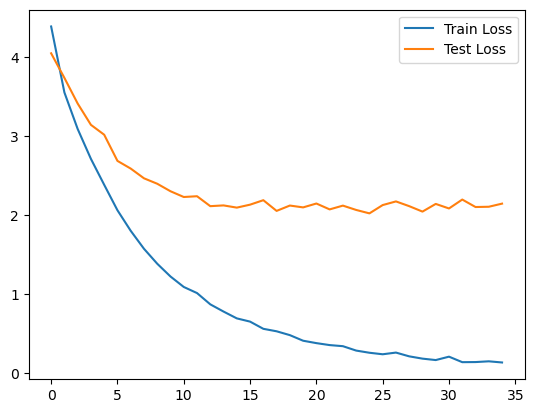

In [36]:
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    running_loss = 0.0
    
    # Training loop
    model.train()
    for i, (_X, _y) in enumerate(train_loader): # использование нижних подчеркиваний перед переменными обычно означает, что эти переменные являются временными
        _X, _y = _X.to(device), _y.to(device)
        optimizer.zero_grad()
        outputs = model(_X)
        loss = criterion(outputs, _y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (_X, _y) in test_loader:
            _X, _y = _X.to(device), _y.to(device)
            outputs = model(_X)
            loss = criterion(outputs, _y)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)

    if best_loss is None or avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

    if no_improve_epochs >= early_stopping_patience:
        print(f'Early stopping triggered. No improvement in {early_stopping_patience} epochs.')
        break

print(f'Best model reinstated with test loss = {best_loss:.4f}')
model.load_state_dict(best_model_state)

plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.legend()
plt.show()    

In [37]:
model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data.astype('float32')).to(device))
    _, predicted = torch.max(outputs, 1)
    f1 =  f1_score(test_labels, predicted.numpy(), average='weighted') 
    accuracy = accuracy_score(test_labels, predicted.numpy())
    print(classification_report(test_labels, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.75      0.60      0.67         5
           2       0.40      0.40      0.40         5
           3       0.30      0.60      0.40         5
           4       0.33      0.20      0.25         5
           5       0.38      0.60      0.46         5
           6       0.80      0.80      0.80         5
           7       1.00      0.40      0.57         5
           8       0.25      0.40      0.31         5
           9       1.00      0.40      0.57         5
          10       0.67      0.40      0.50         5
          11       0.00      0.00      0.00         5
          12       1.00      0.20      0.33         5
          13       0.25      0.20      0.22         5
          14       0.50      0.40      0.44         5
          15       0.00      0.00      0.00         5
          16       0.25      0.20      0.22         5
          17       1.00    

In [38]:
with mlflow.start_run(run_name=f"LSTMModel{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "LSTMModel")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

2024/06/19 12:30:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# CNN1DModel

In [39]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)

    return data, new_labels   


class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]    

In [40]:
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [41]:
device = 'cpu'

train_dataset = KeypointDataset(train_data, train_labels)
test_dataset = KeypointDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [42]:
data_iter = iter(train_loader)
first_batch = next(data_iter)

# Извлекаем данные и метки из первого батча
data, target = first_batch

data.size()

torch.Size([64, 20, 225])

In [43]:
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(225, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*5, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # переставляем размерности для Conv1d
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


In [44]:
num_classes = 100
model = CNN1D(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 60
early_stopping_patience = 10
no_improve_epochs = 0

train_loss_values = [] # в итоге будет длина кол-во эпох
test_loss_values = []

best_loss = None
best_model_state = None

Epoch: 17, Train Loss: 0.436, Test Loss: 3.728:  27%|██▋       | 16/60 [00:16<00:44,  1.01s/it]

Early stopping triggered. No improvement in 10 epochs.
Best model reinstated with test loss = 3.0355


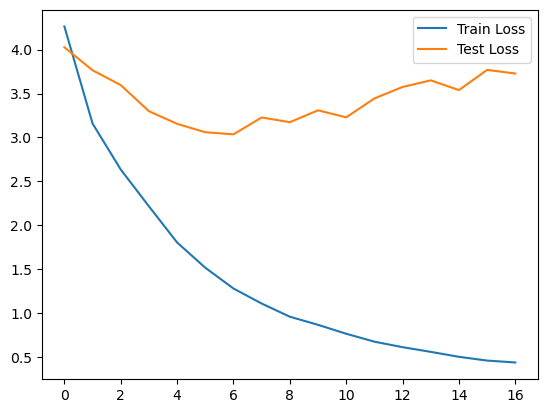

In [45]:
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    running_loss = 0.0
    
    # Training loop
    model.train()
    for i, (_X, _y) in enumerate(train_loader): # использование нижних подчеркиваний перед переменными обычно означает, что эти переменные являются временными
        _X, _y = _X.to(device), _y.to(device)
        optimizer.zero_grad()
        outputs = model(_X)
        loss = criterion(outputs, _y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (_X, _y) in test_loader:
            _X, _y = _X.to(device), _y.to(device)
            outputs = model(_X)
            loss = criterion(outputs, _y)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)

    if best_loss is None or avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

    if no_improve_epochs >= early_stopping_patience:
        print(f'Early stopping triggered. No improvement in {early_stopping_patience} epochs.')
        break

print(f'Best model reinstated with test loss = {best_loss:.4f}')
model.load_state_dict(best_model_state)

plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.legend()
plt.show()   

In [46]:
model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data.astype('float32')).to(device))
    _, predicted = torch.max(outputs, 1)
    f1 =  f1_score(test_labels, predicted.numpy(), average='weighted')
    accuracy = accuracy_score(test_labels, predicted.numpy()) 
    print(classification_report(test_labels, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.12      0.20      0.15         5
           1       0.67      0.40      0.50         5
           2       0.09      0.20      0.12         5
           3       0.20      0.20      0.20         5
           4       0.33      0.20      0.25         5
           5       0.43      0.60      0.50         5
           6       0.75      0.60      0.67         5
           7       1.00      0.80      0.89         5
           8       0.15      0.40      0.22         5
           9       1.00      0.20      0.33         5
          10       0.33      0.40      0.36         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       1.00      0.20      0.33         5
          17       1.00    

In [47]:
with mlflow.start_run(run_name=f"CNN1DModel{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "CNN1DModel")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()

2024/06/19 12:31:30 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# TransformerModel

In [65]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)

    return data, new_labels   


class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]    

In [66]:
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [67]:
device = 'cpu'

train_dataset = KeypointDataset(train_data, train_labels)
test_dataset = KeypointDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [68]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=5, dim_feedforward=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, input_size)  # линейный слой для преобразования размерности входных данных
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Transformer ожидает размерность (seq_len, batch, features)
        x = self.embedding(x)  # Преобразование размерности входных данных
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Усреднение по всем временным шагам
        x = self.fc(x)
        return x


In [79]:
input_size = 225
num_classes = 100
model = TransformerModel(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 60
early_stopping_patience = 10
no_improve_epochs = 0

train_loss_values = [] # в итоге будет длина кол-во эпох
test_loss_values = []

best_loss = None
best_model_state = None

Epoch: 21, Train Loss: 0.184, Test Loss: 2.517:  33%|███▎      | 20/60 [02:45<05:31,  8.30s/it]

Early stopping triggered. No improvement in 10 epochs.
Best model reinstated with test loss = 1.7630


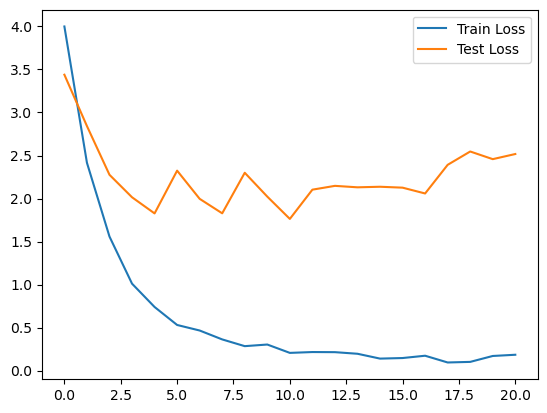

In [80]:
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    running_loss = 0.0
    
    # Training loop
    model.train()
    for i, (_X, _y) in enumerate(train_loader): # использование нижних подчеркиваний перед переменными обычно означает, что эти переменные являются временными
        _X, _y = _X.to(device), _y.to(device)
        optimizer.zero_grad()
        outputs = model(_X)
        loss = criterion(outputs, _y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (_X, _y) in test_loader:
            _X, _y = _X.to(device), _y.to(device)
            outputs = model(_X)
            loss = criterion(outputs, _y)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)

    if best_loss is None or avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

    if no_improve_epochs >= early_stopping_patience:
        print(f'Early stopping triggered. No improvement in {early_stopping_patience} epochs.')
        break

print(f'Best model reinstated with test loss = {best_loss:.4f}')
model.load_state_dict(best_model_state)

plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.legend()
plt.show()  

In [81]:
model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data.astype('float32')).to(device))
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    f1 =  f1_score(test_labels, predicted.numpy(), average='weighted')  
    print(classification_report(test_labels, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       1.00      1.00      1.00         5
           2       0.38      0.60      0.46         5
           3       0.25      0.40      0.31         5
           4       1.00      0.40      0.57         5
           5       0.50      0.40      0.44         5
           6       0.80      0.80      0.80         5
           7       0.67      0.40      0.50         5
           8       1.00      0.40      0.57         5
           9       1.00      0.40      0.57         5
          10       1.00      0.60      0.75         5
          11       1.00      0.20      0.33         5
          12       0.29      0.40      0.33         5
          13       0.43      0.60      0.50         5
          14       1.00      0.20      0.33         5
          15       0.50      0.20      0.29         5
          16       0.50      0.60      0.55         5
          17       0.83    

In [82]:
torch.save(best_model_state, f'best_model_transformer_v1.pth')

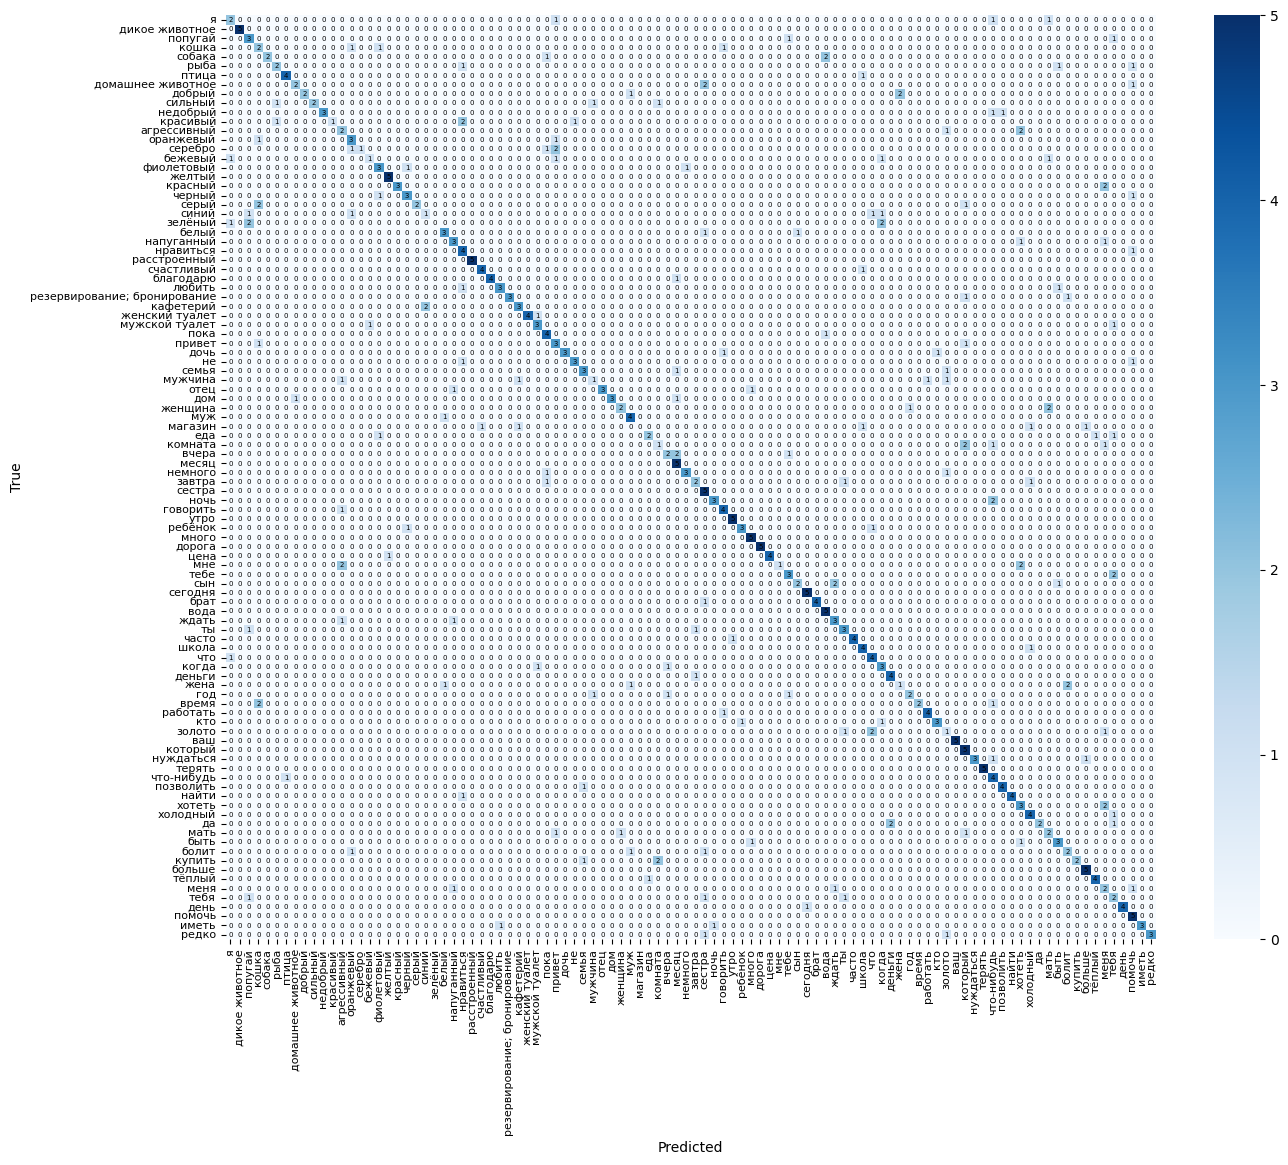

In [84]:
import seaborn as sns

cm = confusion_matrix(test_labels, predicted.numpy())

# class_names = [class_data[label] for label in val_labels]

class_names = [class_data2[label] for label in np.unique(test_labels)]
plt.figure(figsize=(15,12))
sns.heatmap(cm, annot=False,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
# Добавление аннотаций сверху
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j + 0.5, i + 0.5, str(cm[i][j]), ha='center', va='center', color='black', fontsize=5)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [83]:
with mlflow.start_run(run_name=f"TransformerModel{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "TransformerModel")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()  

2024/06/19 21:53:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# ImprovedTransformerModel

In [85]:
def load_keypoints_from_parquet(parquet_file, dataset):
    df = pd.read_parquet(parquet_file)
    if dataset == 'Train':

        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints1 = np.concatenate([df['pose'][df['variation']=='original'].tolist(), df['left_hand'][df['variation']=='original'].tolist(), df['right_hand'][df['variation']=='original'].tolist()], axis=1)
        keypoints2 = np.concatenate([df['pose'][df['variation']=='contrast'].tolist(), df['left_hand'][df['variation']=='contrast'].tolist(), df['right_hand'][df['variation']=='contrast'].tolist()], axis=1)
        keypoints3 = np.concatenate([df['pose'][df['variation']=='sharpness'].tolist(), df['left_hand'][df['variation']=='sharpness'].tolist(), df['right_hand'][df['variation']=='sharpness'].tolist()], axis=1)
        keypoints4 = np.concatenate([df['pose'][df['variation']=='brightness'].tolist(), df['left_hand'][df['variation']=='brightness'].tolist(), df['right_hand'][df['variation']=='brightness'].tolist()], axis=1)
        keypoints5 = np.concatenate([df['pose'][df['variation']=='flipped'].tolist(), df['left_hand'][df['variation']=='flipped'].tolist(), df['right_hand'][df['variation']=='flipped'].tolist()], axis=1)

        keypoints = [keypoints1, keypoints2, keypoints3, keypoints4, keypoints5]

        return keypoints
    
    else:
        # Конкатенируем ключевые точки позы, левой и правой руки в один массив
        keypoints = np.concatenate([df['pose'].tolist(), df['left_hand'].tolist(), df['right_hand'].tolist()], axis=1)

        return [keypoints]

def create_dataset(parquet_files, labels, dataset):
    data = []
    new_labels = []
    for i, file in enumerate(parquet_files):
        keypoints_list = load_keypoints_from_parquet(file, dataset)
        data.extend(keypoints_list)
        
        if dataset == 'Train':
            new_labels.extend([labels[i]] * len(keypoints_list))  # Дублируем метку для всех аугментаций
        else:
            new_labels.append(labels[i])  # Для тестового набора добавляем одну метку

    data = np.array(data)
    new_labels = np.array(new_labels)

    return data, new_labels   


class KeypointDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]    

In [86]:
train_data, train_labels = create_dataset(train_keypoints, label_train, dataset='Train')
test_data, test_labels = create_dataset(test_keypoints, label_test, dataset='Test')

In [88]:
device = 'cpu'

train_dataset = KeypointDataset(train_data, train_labels)
test_dataset = KeypointDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [89]:
data_iter = iter(train_loader)
first_batch = next(data_iter)

# Извлекаем данные и метки из первого батча
data, target = first_batch

data.size()

torch.Size([64, 20, 225])

In [90]:
class ImprovedTransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=5, dim_feedforward=128, num_layers=4):
        super(ImprovedTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, input_size)  # Линейный слой для преобразования размерности входных данных
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Transformer ожидает размерность (seq_len, batch, features)
        x = self.embedding(x)  # Преобразование размерности входных данных
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Усреднение по всем временным шагам
        x = self.fc(x)
        return x

In [92]:
input_size = 225
num_classes = 100
batch_size = 64
seq_len = 20

model = ImprovedTransformerModel(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

n_epochs = 60
early_stopping_patience = 10
no_improve_epochs = 0

train_loss_values = [] # в итоге будет длина кол-во эпох
test_loss_values = []

best_loss = None
best_model_state = None

Epoch: 18, Train Loss: 0.166, Test Loss: 2.038:  28%|██▊       | 17/60 [04:26<11:14, 15.70s/it]

Early stopping triggered. No improvement in 10 epochs.
Best model reinstated with test loss = 1.6605


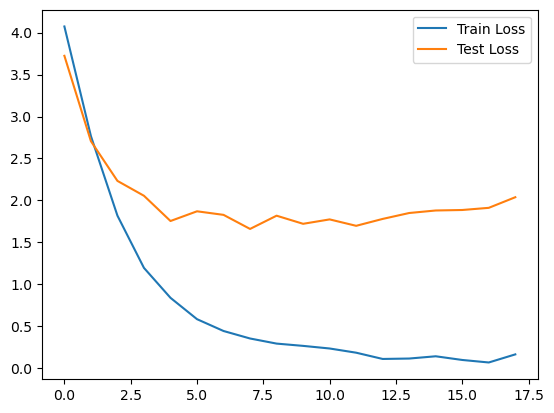

In [93]:
pbar = tqdm(range(n_epochs))

for epoch in pbar:
    running_loss = 0.0
    
    # Training loop
    model.train()
    for i, (_X, _y) in enumerate(train_loader): # использование нижних подчеркиваний перед переменными обычно означает, что эти переменные являются временными
        _X, _y = _X.to(device), _y.to(device)
        optimizer.zero_grad()
        outputs = model(_X)
        loss = criterion(outputs, _y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)
    
    # Testing loop
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for (_X, _y) in test_loader:
            _X, _y = _X.to(device), _y.to(device)
            outputs = model(_X)
            loss = criterion(outputs, _y)
            running_test_loss += loss.item()
    
    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_values.append(avg_test_loss)

    if best_loss is None or avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model_state = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

    if no_improve_epochs >= early_stopping_patience:
        print(f'Early stopping triggered. No improvement in {early_stopping_patience} epochs.')
        break

print(f'Best model reinstated with test loss = {best_loss:.4f}')
model.load_state_dict(best_model_state)

plt.plot(train_loss_values, label='Train Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.legend()
plt.show()  

In [94]:
model.load_state_dict(best_model_state)

model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(test_data.astype('float32')).to(device))
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(test_labels, predicted.numpy())
    f1 =  f1_score(test_labels, predicted.numpy(), average='weighted')  
    print(classification_report(test_labels, predicted.numpy()))

              precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       1.00      0.40      0.57         5
           2       0.33      0.60      0.43         5
           3       0.33      0.20      0.25         5
           4       0.50      0.40      0.44         5
           5       0.50      0.60      0.55         5
           6       1.00      1.00      1.00         5
           7       0.33      0.40      0.36         5
           8       1.00      0.40      0.57         5
           9       0.75      0.60      0.67         5
          10       0.75      0.60      0.67         5
          11       0.50      0.20      0.29         5
          12       0.00      0.00      0.00         5
          13       0.25      0.20      0.22         5
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00         5
          16       0.40      0.40      0.40         5
          17       1.00    

In [95]:
with mlflow.start_run(run_name=f"ImprovedTransformerModel{keypoints_var}"):

    mlflow.log_param("dataset_name", "test_labels")
    mlflow.log_param("dataset_size", len(test_labels))

    mlflow.sklearn.log_model(model, "ImprovedTransformerModel")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    mlflow.end_run()  

2024/06/19 22:09:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
